# Scheduling of the observations by IXPE mission

This notebook is meant to help checking the current planned status of IXPE observations according to "official" [long term plan](https://ixpe.msfc.nasa.gov/for_scientists/ltp.html]) and the HEASAC [viewing tool](https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/viewing/viewing.pl) for IXPE (also for sources not currently in the long-term plan). Code might need to be modified to suit your needs, feel free to do so. 

In [23]:
import urllib.request, sys, re
from pprint import pprint
from html_table_parser.parser import HTMLTableParser
import astropy.time, astropy.io.fits
from pylab import *


def get_visibility(source_name,mission='IXPE'):
    """A simple function to query visibility of an object via visibilty tool from python"""
    xhtml = url_get_contents("https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/viewing/viewing.pl?TOREPLACE&NR=GRB%2FSIMBAD%2BSesame%2FNED&CoordSys=J2000".replace('TOREPLACE',urllib.parse.urlencode({'mission':mission,'Entry':source_name}))).decode('utf-8')
    md = {'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06','Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
    start,stop = transpose([[astropy.time.Time("%s-%s-%s"%(xx.strip().split()[0],md[xx.strip().split()[1]],xx.strip().split()[2])).mjd for xx in x.split('and')] for x in re.findall('Observable between (.*)',str(xhtml))])
    return start, stop

#parse content of the IXPE long-term plan
lpurl = 'https://ixpe.msfc.nasa.gov/for_scientists/ltp.html'
def url_get_contents(url):
    """ Opens a website and read its binary contents (HTTP Response Body) """
    req = urllib.request.Request(url=url)
    f = urllib.request.urlopen(req)
    return f.read()

xhtml = url_get_contents(lpurl).decode('utf-8')
p = HTMLTableParser()
p.feed(xhtml)
# With this table you can get required information. For instance to list sources currently in the plan:
print("Sources currently in observation plan:\n"+", ".join(set([x[1] for x in p.tables[0][1:]])))

Sources currently in observation plan:
Cyg X-2, Cyg X-1, IC 4329A, 4U 1626-67, 3C 273, Cas A, Her X-1, 1RXS J170849.0, MCG-5-23-16, 4U 0142+61, 3C 279, 1ES 1959+650, Vela X-1, Mrk 421, 3C 454.3, Sgr A complex, Mrk 501, GX9+9, GS 1826-238, BL Lac, Cen A, Vela Pulsar, Tycho, Crab, GRS 1915+105, GX 301-2, MSH15-52, S5 0716+714, Circinus galax, J0211+1051, 1ES 0229+200, X Persei


In [24]:
# Or to get planned MJD's for a given source:
source_name='GX 301-2'
date_plan = [x[2] for x in p.tables[0] if x[1]==source_name]
tplan = astropy.time.Time(date_plan).mjd
print(tplan)

[59793.]


With this you can do some neat stuff, i.e. check correspondence of orbital phases and planned dates, visibility windows, etc. For example, for GX 301-2 planned observation matches expected timing of pre-periastron flare

Text(0, 0.5, 'BAT countrate, cts/s')

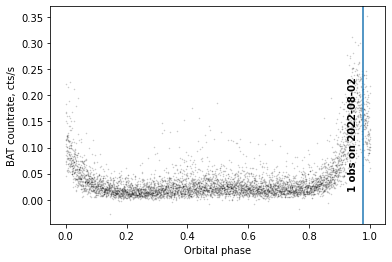

In [40]:
source_name='GX 301-2'
lc = 'https://swift.gsfc.nasa.gov/results/transients/GX301-2.lc.fits'

date_plan = [x[2] for x in p.tables[0] if x[1]==source_name]
tplan = astropy.time.Time(date_plan).mjd
ixpestart,ixpestop = get_visibility(source_name)

t = astropy.io.fits.getdata(lc).field('time')
r = astropy.io.fits.getdata(lc).field('rate')
epoch,p0 = 2453532.15000-2400000.5, 41.47200 # from GBM

plot((t-epoch)/p0%1,r,'k.',ms=1,alpha=0.2)
phplan = (tplan-epoch)/p0%1
axvline(phplan)
[text(x[1][0]-0.05,0.02,"%d obs on %s"%(x[0]+1,x[1][1]),rotation='vertical',weight='bold') for x in enumerate(zip(phplan,date_plan))]
xlabel('Orbital phase')
ylabel('BAT countrate, cts/s')

If it would be a transient source, we could also check if expected outburst timing is covered by one of the visibility windows. For instance, GRO J1008-57 tends to exhibit normal outbursts around the periastron passage, so one can check if any of those are covered by visibility windows by IXPE:

GRO J1008-57 is observable between MJD 59891 and 59909 (corressponding expected ouburst timing is highlighted in green)


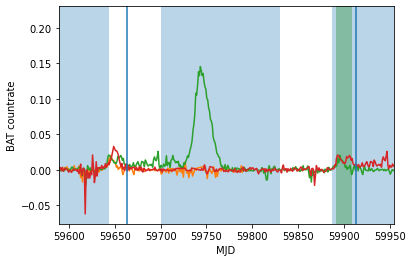

In [51]:
lc='https://swift.gsfc.nasa.gov/results/transients/GROJ1008-57.lc.fits'
t = astropy.io.fits.getdata(lc).field('time')
r = astropy.io.fits.getdata(lc).field('rate')

epoch, p0 = 54424.71,249.48 # epoch and orbital period

clf()
ixpestart,ixpestop = get_visibility('GRO J1008-57')

[plot(t+p0*x,r) for x in [1,2,3,4]] # shift lightcurve by 1-4 orbital periods to see where the outbursts occur
[axvspan(x[0],x[1],alpha=0.3) for x in zip(ixpestart,ixpestop)]
[axvline(epoch+p0*x) for x in range(19,25)] # indicate periastron passage times
xlim(astropy.time.Time(p.tables[0][1][2]).mjd, astropy.time.Time(p.tables[0][1][2]).mjd+365)
axvspan(59891, 59909,alpha=0.3,fc='green')
xlabel('MJD')
ylabel('BAT countrate')
print("%s is observable between MJD %s and %s (corressponding expected ouburst timing is highlighted in green)"%('GRO J1008-57',59891,59909))